Javier Aguilar Martín

# Implementing PCA


First create a data set that looks approximately like 2 concentric circles.

In [1]:
import numpy as np
import numpy.random as nprand
import scipy.linalg as sp_linalg
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('nbagg')
%matplotlib inline

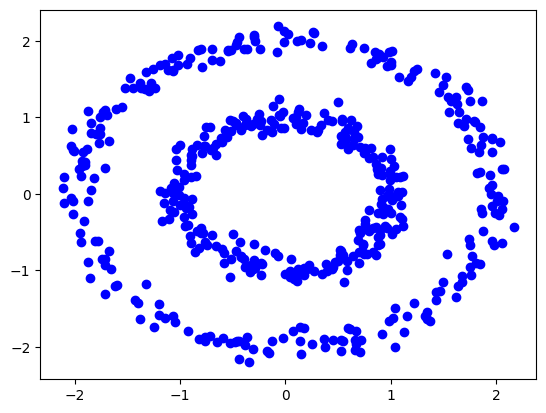

In [2]:
mur, sigmar = 0, 0.1
mut, sigmat = 0, 1
N=250
r1 = 1 + nprand.normal(mur, sigmar, N)
theta1 = 2 * np.pi * nprand.normal(mut, sigmat, N)
r2 = 2 + nprand.normal(mur, sigmar, N)
theta2 = 2 * np.pi * nprand.normal(mut, sigmat, N)

x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

x2 = r2 * np.cos(theta2)
y2 = r2 * np.sin(theta2)

plt.scatter(x1,y1, c = "b")
plt.scatter(x2,y2, c = "b")
plt.show()



Next, implement the squared exponential kernel function:
\begin{equation}
k(\mathbf{x},\mathbf{y}) = \exp \left( -\frac{|\mathbf{x} - \mathbf{y}|^2 }{\sigma^2}\right)
\end{equation}

In [195]:
def exp_kernel(x1 = x1, x2 = x2, sigma = 2, p = 2):
    return np.exp(-sp_linalg.norm(x1-x2, 2)**p/sigma**p)

sigmas = [0.1, 2, 50]
ps = [1,2,3]

1. Set up the Gram matrix

In [197]:
data_size = 2*N
data_points = list(map(lambda p: np.array(p), zip(x1,y1))) + list(map(lambda p: np.array(p), zip(x2,y2)))
def gram_matrix(sigma = 2.0, p = 2, data_points= data_points, kernel = "exponential"):
    kernel = exp_kernel if kernel == "exponential" else kernel
    K = np.zeros((data_size,data_size))
    for i in range(data_size):
        for j in range(data_size):
            K[i,j] = kernel(data_points[i], data_points[j], sigma, p = p)
    return K
K = gram_matrix()
K

array([[1.        , 0.47336685, 0.62591606, ..., 0.16824392, 0.15237539,
        0.359932  ],
       [0.47336685, 1.        , 0.9592853 , ..., 0.79999191, 0.30381186,
        0.75519394],
       [0.62591606, 0.9592853 , 1.        , ..., 0.65094644, 0.2453922 ,
        0.79347966],
       ...,
       [0.16824392, 0.79999191, 0.65094644, ..., 1.        , 0.20847775,
        0.6386788 ],
       [0.15237539, 0.30381186, 0.2453922 , ..., 0.20847775, 1.        ,
        0.07222128],
       [0.359932  , 0.75519394, 0.79347966, ..., 0.6386788 , 0.07222128,
        1.        ]])

2. Compute the centered matrix $\tilde{K}$.

In [169]:
I_N = 1/data_size * np.ones((data_size, data_size))
def centered_matrix(K):
    K_tilde = K - I_N @ K - K @ I_N + I_N @ K @ I_N 
    return K_tilde
K_tilde = centered_matrix(K)
K_tilde

array([[ 0.35540424, -0.13190114, -0.01053413, ..., -0.27515216,
        -0.28150755, -0.13177864],
       [-0.13190114,  0.43405978,  0.36216288, ...,  0.3959236 ,
        -0.0907433 ,  0.30281108],
       [-0.01053413,  0.36216288,  0.37169538, ...,  0.21569593,
        -0.18034517,  0.30991459],
       ...,
       [-0.27515216,  0.3959236 ,  0.21569593, ...,  0.7578036 ,
        -0.02420551,  0.34816785],
       [-0.28150755, -0.0907433 , -0.18034517, ..., -0.02420551,
         0.77682988, -0.20877654],
       [-0.13177864,  0.30281108,  0.30991459, ...,  0.34816785,
        -0.20877654,  0.66117449]])

3. Compute eigen-decomposition of $\tilde{K}$.

In [171]:
def eigen_decomposition(K_tilde):
    l, a = sp_linalg.eigh(K_tilde)
    return l[::-1], a[:, ::-1]

l, a = eigen_decomposition(K_tilde)
#np.isclose(K_tilde @ a[:,0], l[0]*a[:,0]), l[0] > l[1], np.isclose(sp_linalg.norm(a[:,0],2),1)


4. Compute the new coordinates

In [198]:
def new_coordinates(data_points, sigma, p, d=3):
    new_data_points = []
    K = gram_matrix(sigma = sigma, p = p, data_points=data_points)
    K_tilde = centered_matrix(K)
    l, a = eigen_decomposition(K_tilde)
    lambdas = l[:d]
    vectors = a[:,:d]
    for i in range(len(data_points)):
        Ki = K_tilde[i,:]
        y = 1/np.sqrt(lambdas) * np.array([np.dot(Ki, col) for col in vectors.T])
        new_data_points.append(y)
    return new_data_points


 Plots for $d=1$, using different values of $\sigma$ and different exponential kernels.

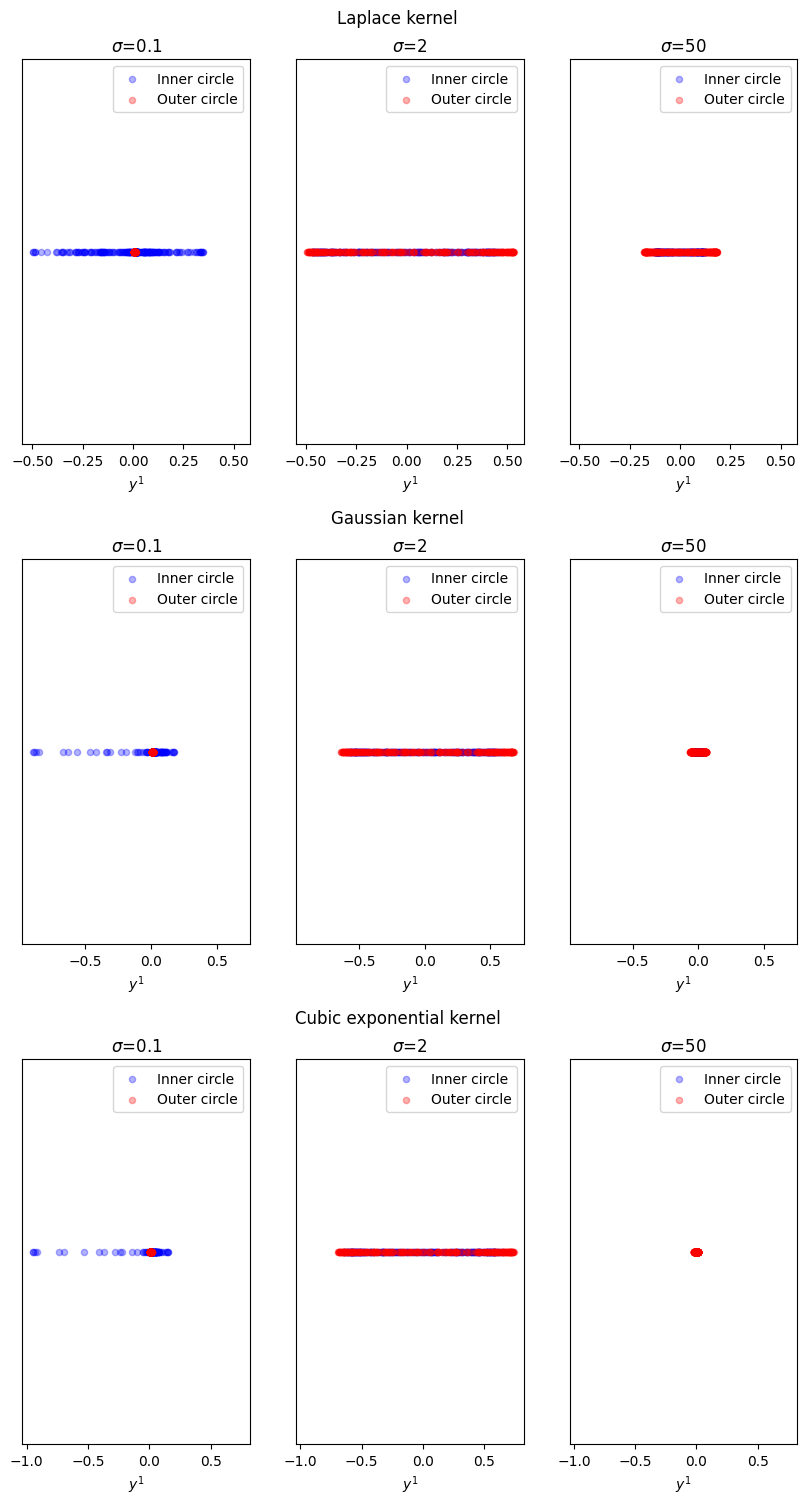

In [247]:
#fig, ax = plt.subplots(3,3, figsize = (10,5), sharey=True)
fig = plt.figure(figsize=(10,15))
subfigs = fig.subfigures(nrows=3, ncols=1)
for i in range(3):
    if i == 0:
        title = "Laplace kernel"
    elif i == 1:
        title = "Gaussian kernel"
    else:
        title = "Cubic exponential kernel"
    subfigs[i].suptitle(title)
    ax = subfigs[i].subplots(nrows = 1, ncols = 3, sharey= True, sharex = True)
    for j in range(3):
        one_d_points = new_coordinates(data_points, sigma=sigmas[j], p = ps[i], d=1)
        ax[j].scatter(one_d_points[:N], np.zeros_like(one_d_points[:N]), c = "b", alpha= 0.3, s = 20, label = "Inner circle")
        ax[j].scatter(one_d_points[N:], np.zeros_like(one_d_points[N:]), c = "r", alpha= 0.3, s=20, label = "Outer circle")
        ax[j].set_xlabel("$y^1$")
        ax[j].set_title(f"$\sigma$={sigmas[j]}")
        ax[j].set_yticks([])
        ax[j].set_ylim(-0.1,0.1)
        ax[j].legend()
plt.show()

Plots for $d=2$

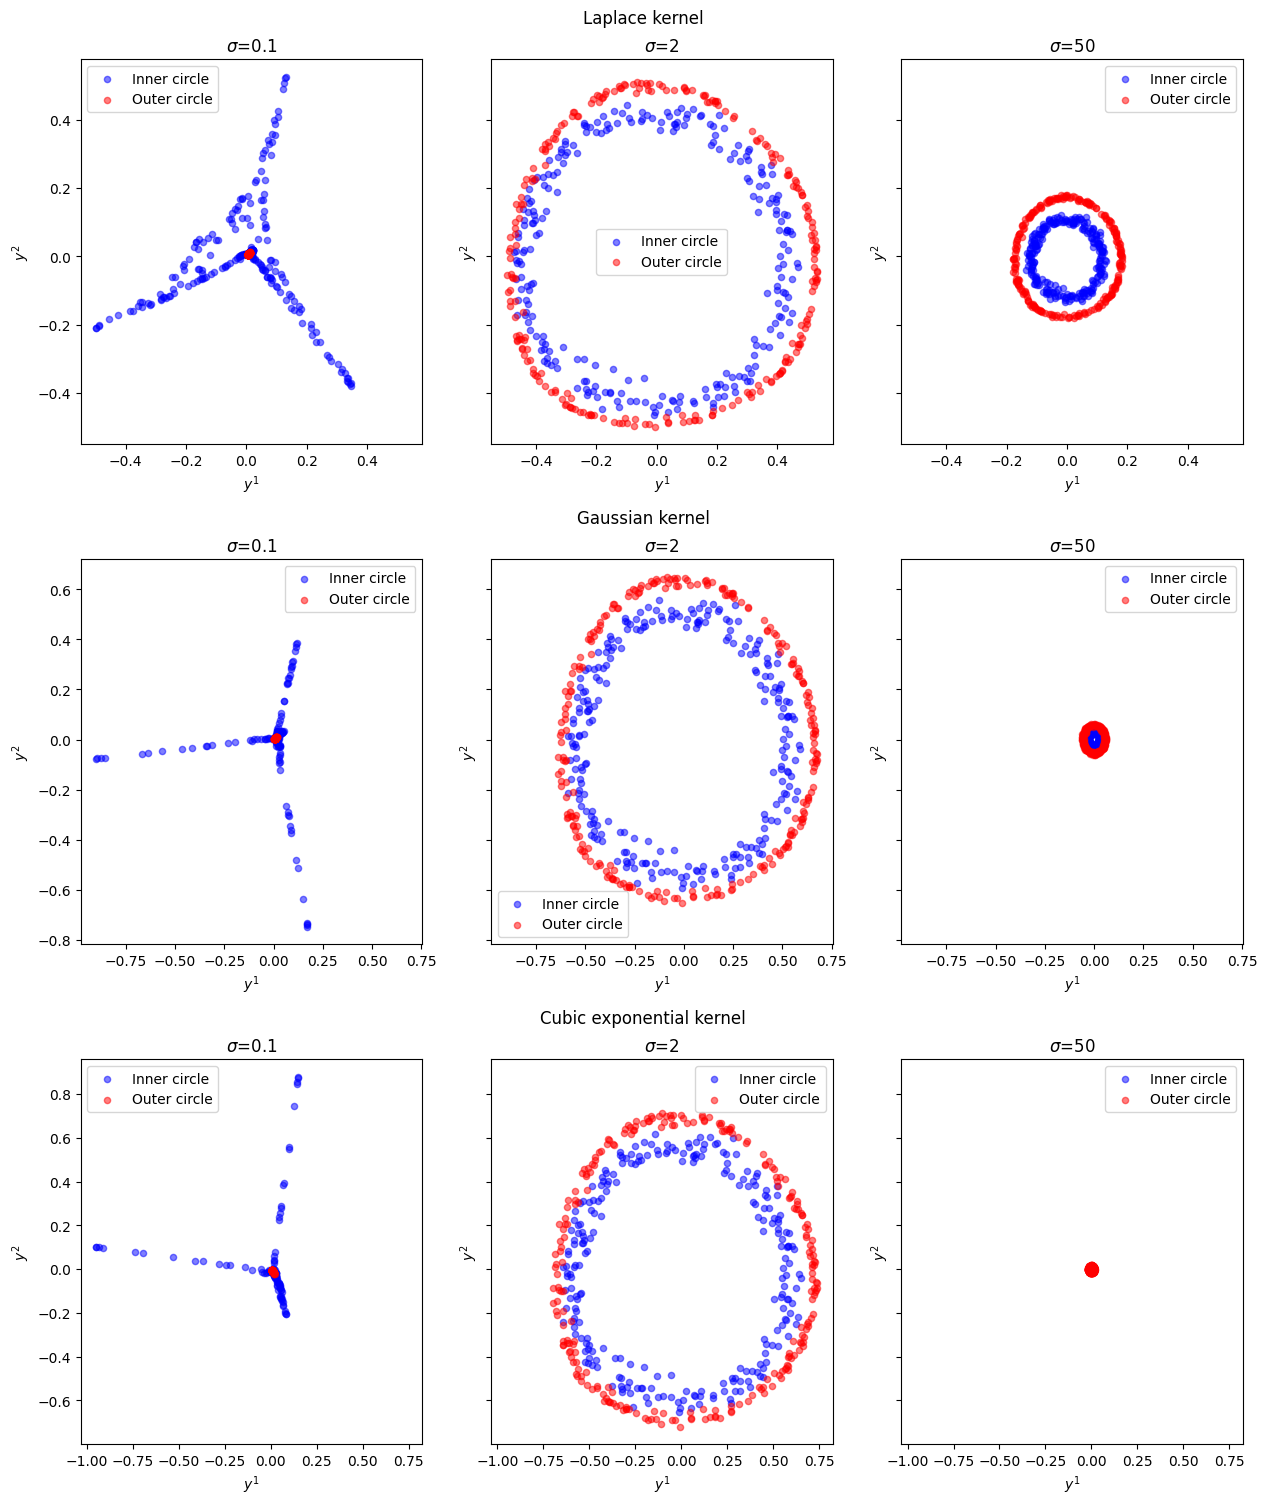

In [246]:

#fig, ax = plt.subplots(1,3, figsize = (15,5), sharey=True)
fig = plt.figure(figsize=(15,15))
subfigs = fig.subfigures(nrows=3, ncols=1)
for i in range(3):
    if i == 0:
        title = "Laplace kernel"
    elif i == 1:
        title = "Gaussian kernel"
    else:
        title = "Cubic exponential kernel"
    subfigs[i].suptitle(title)
    ax = subfigs[i].subplots(nrows = 1, ncols = 3, sharey= True, sharex = True)   
    for j in range(3):
        two_d_points = new_coordinates(data_points, sigma = sigmas[j], p = ps[i], d=2)
        inner_circle = two_d_points[:N]
        outer_circle = two_d_points[N:]
        ax[j].scatter(*zip(*inner_circle), c = "b", alpha= 0.5, s = 20, label = "Inner circle")
        ax[j].scatter(*zip(*outer_circle), c = "r", alpha= 0.5, s=20, label = "Outer circle")
        ax[j].set_xlabel("$y^1$")
        ax[j].set_ylabel("$y^2$")
        ax[j].set_title(f"$\sigma$={sigmas[j]}")
        ax[j].legend()
plt.show()

Plot for $d=3$

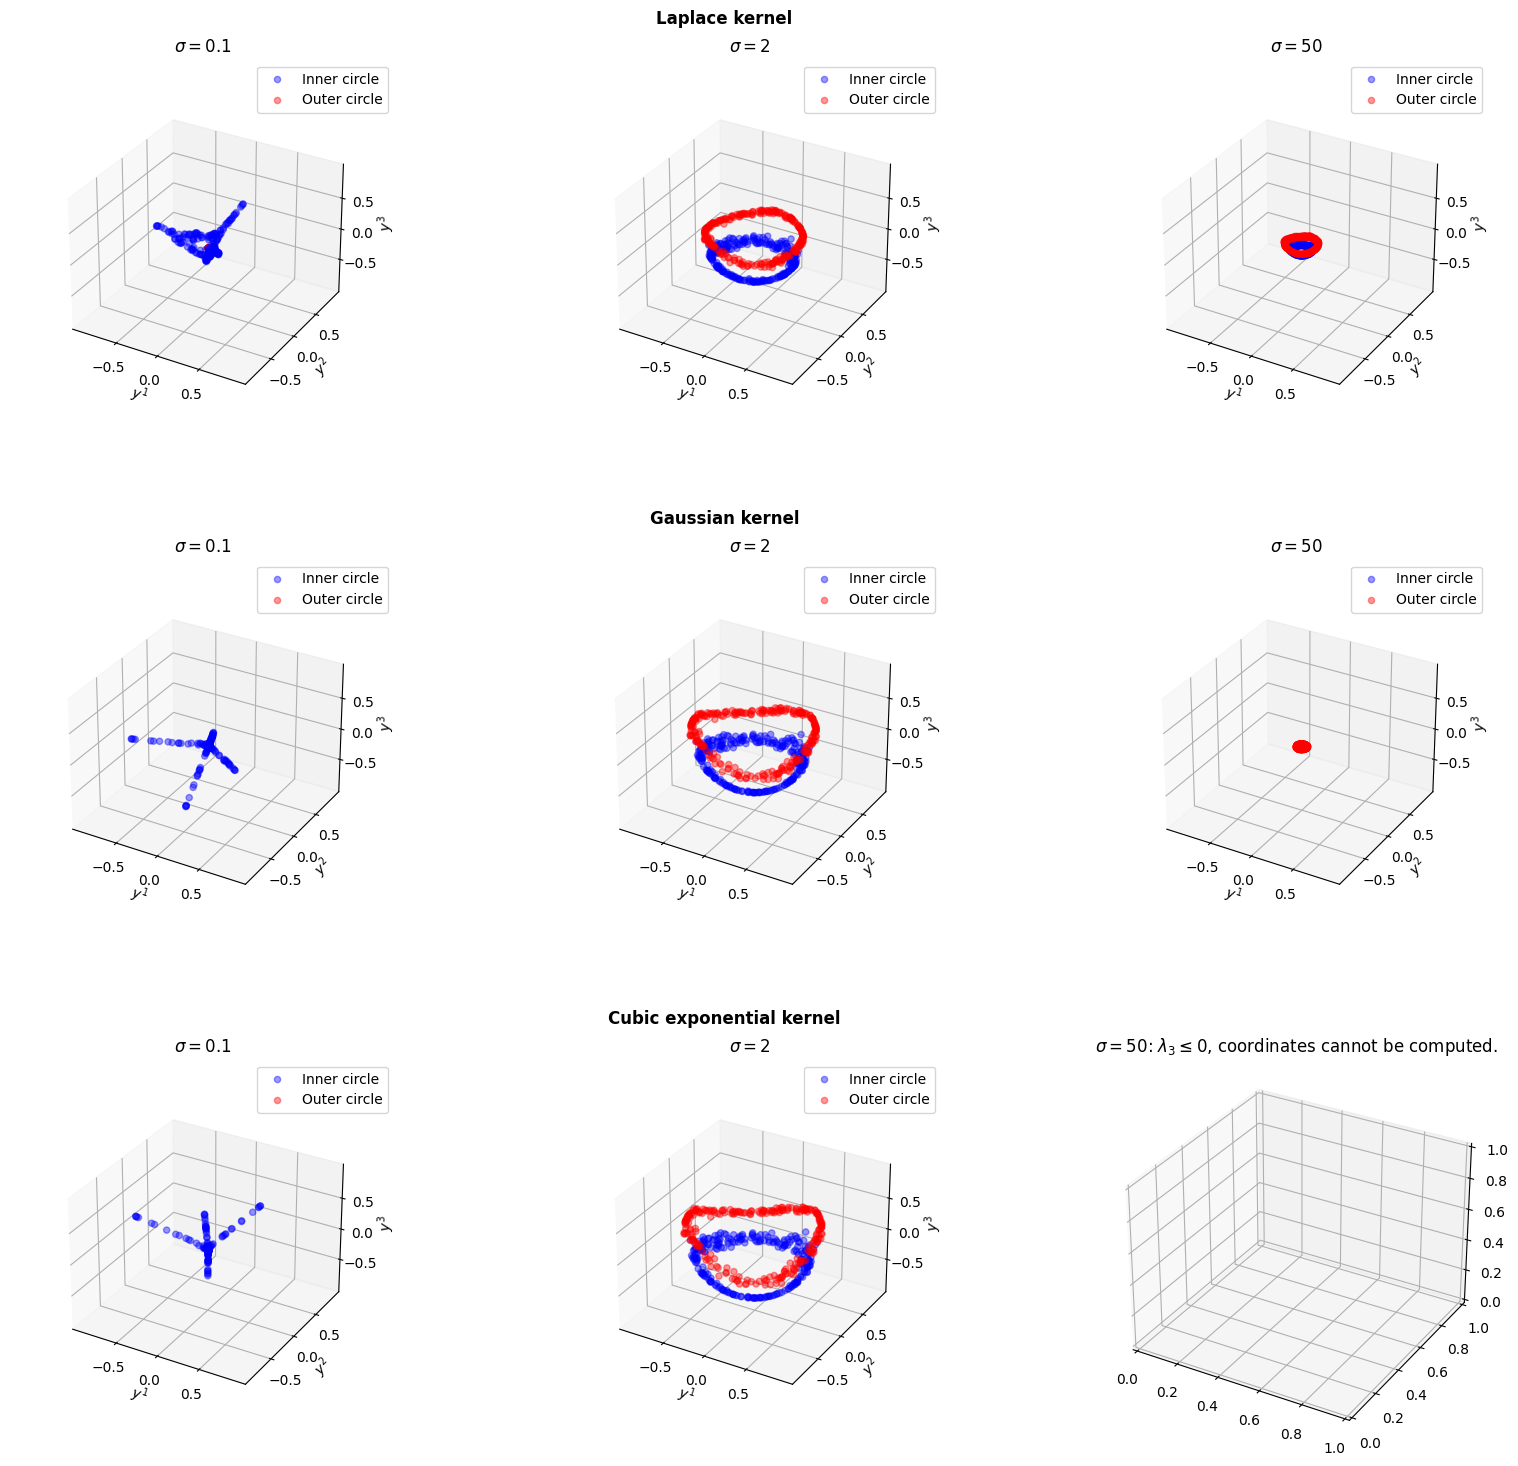

In [257]:
fig = plt.figure(figsize=(20,15))

#fig.subplots_adjust(right=0.2, left=0)
subfigs = fig.subfigures(nrows=3, ncols=1)
for i in range(3):
    if i == 0:
        title = "Laplace kernel"
    elif i == 1:
        title = "Gaussian kernel"
    else:
        title = "Cubic exponential kernel"
    ax = subfigs[i]
    ax.suptitle(title, fontweight = "bold")
    
    #.subplots(nrows = 1, ncols = 3, projection = "3d")
    for j in range(3):
        ax = subfigs[i].add_subplot(1,3,j+1,projection='3d')
        if i == j == 2:
            ax.set_title("$\sigma = 50$: $\lambda_3 \leq 0$, coordinates cannot be computed.")
            continue
        three_d_points = new_coordinates(data_points, sigma=sigmas[j], p = ps[i], d=3)
        # max_x = max(map(lambda p : p[0], three_d_points))
        # min_x = min(map(lambda p : p[0], three_d_points))
        # max_y = max(map(lambda p : p[1], three_d_points))
        # min_y = min(map(lambda p : p[1], three_d_points))
        # max_z = max(map(lambda p : p[2], three_d_points))
        # min_z = min(map(lambda p : p[2], three_d_points))
        inner_circle = three_d_points[:N]
        outer_circle = three_d_points[N:]
        
        
        ax.scatter(*zip(*inner_circle), c = "b", alpha= 0.4, s = 20, label = "Inner circle")
        ax.scatter(*zip(*outer_circle), c = "r", alpha= 0.4, s=20, label = "Outer circle")
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        ax.set_xticks(np.arange(-0.5,1, 0.5))
        ax.set_yticks(np.arange(-0.5,1, 0.5))
        ax.set_zticks(np.arange(-0.5,1, 0.5))
        #ax.set_xticks(np.arange(min_x,max_x, (max_x-min_x)/2))
        # ax.set_yticks(np.arange(min_y,max_y, (max_y-min_y)/2))
        # ax.set_zticks(np.arange(min_z,max_z, (max_z-min_z)/2))
        
        # if j != 2:
        #     ax.set_xticks(np.arange(-0.5,1, 0.5))
        #     ax.set_yticks(np.arange(-0.5,1, 0.5))
        #     ax.set_zticks(np.arange(-0.5,1, 0.5))
        #  else:
        #     ax.set_xticks(np.arange(-0.05,0.09, 0.05))
        #     ax.set_yticks(np.arange(-0.05,0.09, 0.05))
        #     ax.set_zticks(np.arange(-0.05,0.09, 0.05))
        ax.set_xlabel("$y^1$")
        ax.set_ylabel("$y^2$")
        ax.set_zlabel("$y^3$")
        ax.set_title(f"$\sigma=${sigmas[j]}")
        #ax.dist = 13
        ax.set_box_aspect(aspect=None, zoom=0.8)
        ax.legend()

plt.show()

For $\sigma = 2$ we get similar plots to the lecture notes. For for $\sigma = 50$ and $d=s=3$ we found that $\lambda_s\approx 0^-$.

In [262]:
k3 = gram_matrix(sigma = 50, p=3)
k3tilde = centered_matrix(k3)
l,a = eigen_decomposition(k3tilde)
l[2]

-4.310368327529881e-14

In [260]:
#  fig = plt.figure(figsize=(20,9))

# fig.subplots_adjust(right=0.6, left=0)

# for i in range(3):
#         three_d_points = new_coordinates(data_points, sigma=sigmas[i], p = 3, d=3)
#         inner_circle = three_d_points[:N]
#         outer_circle = three_d_points[N:]
#         ax = fig.add_subplot(1,3,i+1,projection='3d')
#         ax.scatter(*zip(*inner_circle), c = "b", alpha= 0.4, s = 20, label = "Inner circle")
#         ax.scatter(*zip(*outer_circle), c = "r", alpha= 0.4, s=20, label = "Outer circle")
#         if i != 2:
#             ax.set_xticks(np.arange(-0.5,1, 0.5))
#             ax.set_yticks(np.arange(-0.5,1, 0.5))
#             ax.set_zticks(np.arange(-0.5,1, 0.5))
#         else:
#             ax.set_xticks(np.arange(-0.05,0.09, 0.05))
#             ax.set_yticks(np.arange(-0.05,0.09, 0.05))
#             ax.set_zticks(np.arange(-0.05,0.09, 0.05))
#         ax.set_xlabel("$y^1$")
#         ax.set_ylabel("$y^2$")
#         ax.set_zlabel("$y^3$")
#         ax.set_title(f"$\sigma=${sigmas[i]}")
#         #ax.dist = 13
#         ax.set_box_aspect(aspect=None, zoom=0.8)
#         ax.legend()

# plt.show()